# Q-learning in OpenAI Gym: Frozen Lake

Author: Juvid Aryaman

In [1]:
import gym
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
sys.path.append("..")
import utls
utls.reset_plots()

In [8]:
env = gym.make("FrozenLake-v0")

In [20]:
observation = env.reset()

for t in range(100):
    env.render()
    print(observation)
    action = env.action_space.sample() # make a random action
    observation, reward, done, info = env.step(action)
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break


SFFF
FHFH
FFFH
HFFG
0
  (Down)
SFFF
FHFH
FFFH
HFFG
1
  (Right)
SFFF
FHFH
FFFH
HFFG
2
  (Left)
SFFF
FHFH
FFFH
HFFG
6
Episode finished after 4 timesteps


The action-value function $Q_{\pi}(s,a)$ indicates how good it is, in state $s$, to first take action $a$ before continuing to follow policy $\pi$ for all other next actions.

$$Q_{\pi}(s,a) = \mathbb{E}_{\pi}[\sum_{i=0}^\infty r_{t+i} | S_t = s, A_t = a]$$

Initialise $Q$

In [143]:
Q_init = np.zeros([env.observation_space.n, env.action_space.n])
Q_init.shape

(16, 4)

So $Q$ is simply a look-up table of all actions for all states. The state is a 4x4 grid (so 16-dimensional), and there are 4 possible actions.

In [160]:
alpha = 0.1 # learning rate
gamma = 0.99 # discount factor

In [161]:
def Tabular_Q_learning(alpha, gamma, epsilons, episodes, Q_init, TMAX=100):
    Q = Q_init
    rewards = [] # for each episode
    ts = []
    for i in range(episodes):
        epsilon = epsilons[i]
        
        if i % 1000 == 0:
            print(i)
        # reset environment
        s = env.reset()
        t = 0
        r_all = 0.0
        done = False
        while t < TMAX:            
            # Choose action from epsilon-greedy policy using Q
            if np.random.uniform()<epsilon:
                a = env.action_space.sample() # make a random action
            else:
                a = np.argmax(Q[s,:])

            s_new, r, done, _ = env.step(a)

            # Update Q-Table
            Q[s,a] = Q[s,a] + alpha*(r + gamma*np.max(Q[s_new,:]) - Q[s,a])

            r_all += r
            s = s_new
            t += 1
            if done:
                ts.append(t)
                break
        rewards.append(r_all)
    rewards = np.array(rewards)
    print("Done.")
    return Q, rewards, ts

In [162]:
episodes = 5000
Q, rewards_e_0_5, ts = Tabular_Q_learning(alpha, gamma, 0.5*np.ones(episodes),episodes, Q_init)
Q, rewards_e_0_3, ts = Tabular_Q_learning(alpha, gamma, 0.3*np.ones(episodes),episodes, Q_init)
Q, rewards_e_0_1, ts = Tabular_Q_learning(alpha, gamma, 0.1*np.ones(episodes),episodes, Q_init)

0
1000
2000
3000
4000
Done.
0
1000
2000
3000
4000
Done.
0
1000
2000
3000
4000
Done.


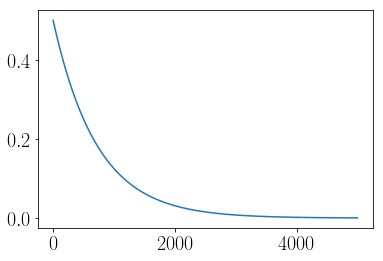

In [165]:
k = np.log(2)/(episodes/10)
t = np.arange(episodes)
plt.plot(t,0.5*np.exp(-k*t))

In [166]:
Q, rewards_e_anneal, ts = Tabular_Q_learning(alpha, gamma, 0.5*np.exp(-k*t),episodes, Q_init)

0
1000
2000
3000
4000
Done.


Bin the reward per episode to smooth the signal, so we may inspect it

In [175]:
def smooth_rewards(rewards, bin_length = 100):
    nbins = int(len(rewards)/bin_length)
    mean_reward_binned = []
    std_reward_binned = []
    for i in np.arange(nbins,dtype=int):
        mean_reward = np.mean(rewards[i*bin_length:i*bin_length+bin_length])
        std_reward = np.std(rewards[i*bin_length:i*bin_length+bin_length],ddof=1)
        mean_reward_binned.append(mean_reward)
        std_reward_binned.append(std_reward)
    mean_reward_binned = np.array(mean_reward_binned)
    std_reward_binned = np.array(std_reward_binned)
    return mean_reward_binned, std_reward_binned, nbins

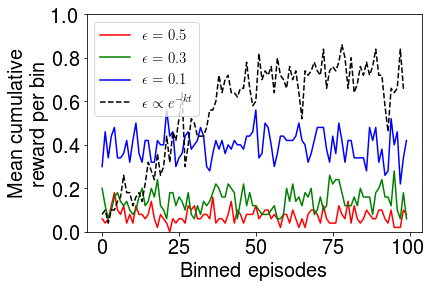

In [177]:
bin_length = 50
mean_reward_binned_5, std_reward_binned_5, nbins_5 = smooth_rewards(rewards_e_0_5, bin_length)
mean_reward_binned_3, std_reward_binned_3, nbins_3 = smooth_rewards(rewards_e_0_3, bin_length)
mean_reward_binned_1, std_reward_binned_1, nbins_1 = smooth_rewards(rewards_e_0_1, bin_length)
mean_reward_binned_a, std_reward_binned_a, nbins_a = smooth_rewards(rewards_e_anneal, bin_length)

fig, ax = plt.subplots(1,1)
ax.plot(np.arange(nbins_5), mean_reward_binned_5,'-r', label = "$\epsilon=0.5$")
ax.plot(np.arange(nbins_3), mean_reward_binned_3,'-g', label = "$\epsilon=0.3$")
ax.plot(np.arange(nbins_1), mean_reward_binned_1,'-b', label = "$\epsilon=0.1$")
ax.plot(np.arange(nbins_a), mean_reward_binned_a,'--k', label = "$\epsilon\propto e^{-kt}$")

utls.remove_tex_axis(ax,ytick_fmt="%.1f")
ax.set_xlabel('Binned episodes')
ax.set_ylabel('Mean cumulative\n reward per bin')
ax.set_ylim([0,1])
ax.legend()

So reducing $\epsilon$ makes us learn better! Annealing $\epsilon$ is better still.

## Use the SARSA algorithm

In [178]:
def Tabular_Q_learning_SARSA(alpha, gamma, epsilons, episodes, Q_init, TMAX=100):
    Q = Q_init
    rewards = [] # for each episode
    ts = []
    for i in range(episodes):
        epsilon = epsilons[i]
        
        if i % 1000 == 0:
            print(i)
        # reset environment
        s = env.reset()
        a = 0
        t = 0
        r_all = 0.0
        done = False
        while t < TMAX:            
            # Choose action from epsilon-greedy policy using Q
            if np.random.uniform()<epsilon:
                a_new = env.action_space.sample() # make a random action
            else:
                a_new = np.argmax(Q[s,:])

            s_new, r, done, _ = env.step(a_new)

            # Update Q-Table
            Q[s,a] = Q[s,a] + alpha*(r + gamma*np.max(Q[s_new,a_new]) - Q[s,a])

            r_all += r
            s = s_new
            t += 1
            a = a_new
            if done:
                ts.append(t)
                break
        rewards.append(r_all)
    rewards = np.array(rewards)
    print("Done.")
    return Q, rewards, ts

In [185]:
Q, rewards_e_a_SARSA, ts = Tabular_Q_learning_SARSA(alpha, gamma, 0.5*np.exp(-k*t),episodes, Q_init)

0
1000
2000
3000
4000
Done.


In [186]:
mean_reward_binned_a_SARSA, std_reward_binned_a_SARSA, nbins_a_SARSA = smooth_rewards(rewards_e_a_SARSA, bin_length)

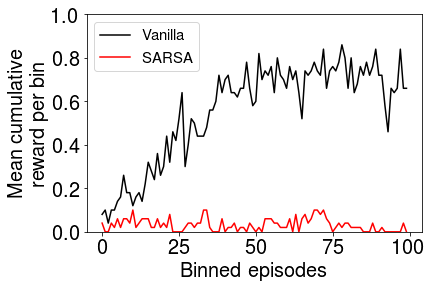

In [187]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(nbins_a), mean_reward_binned_a,'-k', label = "Vanilla")
ax.plot(np.arange(nbins_a), mean_reward_binned_a_SARSA,'-r', label = "SARSA")

utls.remove_tex_axis(ax,ytick_fmt="%.1f")
ax.set_xlabel('Binned episodes')
ax.set_ylabel('Mean cumulative\n reward per bin')
ax.set_ylim([0,1])
ax.legend()

Hmmm... SARSA doesn't seem to be very good!!

To do: Convert to `TensorFlow`